In [1]:
import pandas as pd
import scipy
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns
import pymc3 as pm
sns.set(style="darkgrid")

## Preparing the dataset

Here, we will prepare the dataset with the data that we created in chapter three. For an explanation, see the notebook for chapter 3 as well as chapter 3 in the book.

In [2]:
# create batting average dataset (sum over years)
batting = pd.read_csv("~/baseball/core/Batting.csv")
pitching = pd.read_csv("~/baseball/core/Pitching.csv")
#pitching = pitching.loc[pitching["gamesPitched"]]

In [3]:
pitching = pitching.groupby("playerID").agg({"G": "sum"})

In [4]:
# create batting average dataset (sum over years)
batting = pd.read_csv("~/baseball/core/Batting.csv")
pitching = pd.read_csv("~/baseball/core/Pitching.csv")
pitching = pitching.groupby("playerID").agg({"G": "sum"}).reset_index()
pitching = pitching.loc[pitching["G"]>3]
# filter pitchers with 4+ games
batting_pitchers = batting.playerID.isin(pitching.playerID)
batting = batting[~batting_pitchers]
# sum over seasons
batting = batting.loc[batting["AB"] > 0].groupby("playerID").agg({"AB": "sum", "H": "sum"})
batting["average"] = batting["H"]/batting["AB"]
# add actual player name
people = pd.read_csv("~/baseball/core/People.csv")
people["name"] = people["nameFirst"] + " " + people["nameLast"]
batting = batting.merge(people[["playerID", "name"]], on="playerID")
# I am using the book values here, not the values that we got in our last notebook. I think the difference comes
# from the fact that we are using more data (data from more recent seasons).
alpha_0 = 101.4
beta_0 = 287.3
# add empirical Bayes estimate
# this is called a point estimate
batting["eb_estimate"] = (batting["H"] + alpha_0) / (batting["AB"] + alpha_0 + beta_0)
batting["alpha_1"] = alpha_0 + batting["H"]
batting["beta_1"] = beta_0 + batting["AB"] - batting["H"]
# sort by eb_estimate
batting = batting.sort_values("eb_estimate", ascending=False)

In [5]:
batting.head()

,playerID,AB,H,average,name,eb_estimate,alpha_1,beta_1
1791,cobbty01,11435,4189,0.366331,Ty Cobb,0.362864,4290.4,7533.3
4512,hornsro01,8173,2930,0.358497,Rogers Hornsby,0.354065,3031.4,5530.3
4720,jacksjo01,4981,1772,0.355752,Shoeless Joe Jackson,0.348884,1873.4,3496.3
465,barnero01,2391,860,0.359682,Ross Barnes,0.345865,961.4,1818.3
2377,delahed01,7510,2597,0.345806,Ed Delahanty,0.341626,2698.4,5200.3


Let's compare AB (at-bats) with our raw batting average:

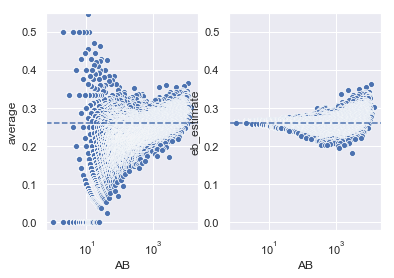

In [6]:
fig, ax =plt.subplots(1,2)
sns.scatterplot(batting["AB"], batting["average"], ax=ax[0])
sns.scatterplot(batting["AB"], batting["eb_estimate"], ax=ax[1])
ax[0].set_xscale('log')
ax[0].set(ylim=(-0.02, 0.55));
ax[1].set_xscale('log')
ax[1].set(ylim=(-0.02, 0.55));
ax[0].axhline(0.261, ls='--')
ax[1].axhline(0.261, ls='--')

We can see that the batting average increases with number of games played! We are also systematically overestimating the batter abilities! In order to improve the model, we will account for AB directly in our model. We want to have the typical batting average to be influenced by `log(AB)`:

In [7]:
# taken from https://stackoverflow.com/questions/54505173/finding-alpha-and-beta-of-beta-binomial-distribution-with-scipy-optimize-and-log
from scipy.special import gammaln, logit

def loglike_betabinom(params, *args):

    k = args[0] # the OVERALL conversions
    n = args[1] # the number of at-bats (AE)

    a, b = params[0] + params[1] * np.log(n), 1/params[2] - params[0] - params[1] * np.log(n)

    logpdf = gammaln(n+1) + gammaln(k+a) + gammaln(n-k+b) + gammaln(a+b) - \
     (gammaln(k+1) + gammaln(n-k+1) + gammaln(a) + gammaln(b) + gammaln(n+a+b))

    return -np.sum(logpdf) 
#     mask = np.isfinite(logpdf)
#     nll = -logpdf[mask].sum()
#     return nll

In [ ]:
from scipy.special import comb, betaln

def BetaBinomAnalytic(x, n, alpha, beta):
    # log sum exp,
    part_1 = gammaln(n+1) - gammaln(x+1) - gammaln(n-x+1) #comb(n,x)#
    part_2 = betaln(x+alpha,n-x+beta)
    part_3 = betaln(alpha,beta)

    result = (part_1 + part_2) - part_3

    return np.exp(result)

In [9]:
batting_cor = batting.loc[batting["H"] > 0]

In [10]:
# the trick here is to set a non-zero lower bound for sigma
# however, the regression is crazy sensitive to initial parameter guesses...
# the diagonal in parameter space seems to be working well. It doesn't matter
# what parametrization I choose...
from scipy.optimize import minimize

init_params = [0.1, 0.1, 0.1]
res = minimize(loglike_betabinom, x0=init_params,
            args=(batting_cor['H'], batting_cor['AB']),
            method='L-BFGS-B', options={'disp': True, 'maxiter': 500},
              bounds=[(1, None), (0.00001, None), (0.0001, None)])
print(res)

      fun: 37398.29487293131
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([1.32422429e-01, 2.04454409e-01, 3.87681648e+03])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 600
      nit: 94
   status: 0
  success: True
        x: array([8.20430077e+01, 7.74412841e+00, 1.83459328e-03])


In [ ]:
from scipy.special import beta
def beta_pdf(x, mu_0, mu_ab, sigma, ab):
    num = x**((mu_0 + mu_ab*np.log(ab))-1)

In [11]:
alpha_0, alpha_ab, sigma = res.x

In [12]:
batting["alpha_0"] = alpha_0 + alpha_ab * np.log(batting["AB"])
batting["beta_0"]= 1/sigma - batting["alpha_0"]
batting["alpha_1"] = batting["alpha_0"] + batting["H"]
batting["beta_1"] = batting["beta_0"] + batting["AB"] - batting["H"]
batting["new_eb"] = batting["alpha_1"] / (batting["alpha_1"] + batting["beta_1"])

In [13]:
batting.head()

,playerID,AB,H,average,name,eb_estimate,alpha_1,beta_1,alpha_0,beta_0,new_eb
1791,cobbty01,11435,4189,0.366331,Ty Cobb,0.362864,4343.407505,7636.672437,154.407505,390.672437,0.362552
4512,hornsro01,8173,2930,0.358497,Rogers Hornsby,0.354065,3081.806696,5636.273247,151.806696,393.273247,0.353496
4720,jacksjo01,4981,1772,0.355752,Shoeless Joe Jackson,0.348884,1919.971762,3606.108181,147.971762,397.108181,0.347438
465,barnero01,2391,860,0.359682,Ross Barnes,0.345865,1002.288199,1933.791744,142.288199,402.791744,0.341370
2377,delahed01,7510,2597,0.345806,Ed Delahanty,0.341626,2748.151538,5306.928404,151.151538,393.928404,0.341170


The minimization is very fickle. In the other notebook we are using MCMC to approximate the parameters.

Let's compare all three:

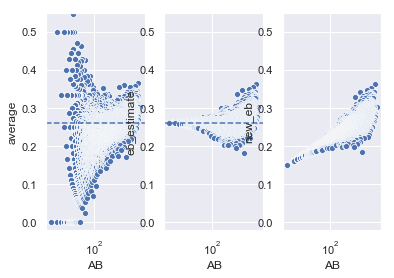

In [14]:
fig, ax =plt.subplots(1,3)
sns.scatterplot(batting["AB"], batting["average"], ax=ax[0])
sns.scatterplot(batting["AB"], batting["eb_estimate"], ax=ax[1])
sns.scatterplot(batting["AB"], batting["new_eb"], ax=ax[2])
ax[0].set_xscale('log')
ax[0].set(ylim=(-0.02, 0.55));
ax[1].set_xscale('log')
ax[1].set(ylim=(-0.02, 0.55));
ax[2].set_xscale('log')
ax[2].set(ylim=(-0.02, 0.55));
ax[0].axhline(0.261, ls='--');
ax[1].axhline(0.261, ls='--');

We can also compare the new estimate with the old estimate:

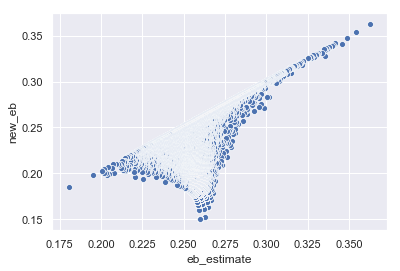

In [15]:
sns.scatterplot(batting["eb_estimate"], batting["new_eb"])